# **Fight detection using Video dataset**

* Dataset link: [https://www.kaggle.com/datasets/naveenk903/movies-fight-detection-dataset/data?select=Peliculas](https://www.kaggle.com/datasets/naveenk903/movies-fight-detection-dataset/data?select=Peliculas)

* Classes (targets):
    1) Fight
    2) No Fight

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

2024-06-21 16:56:11.074851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 16:56:11.074955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 16:56:11.207276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


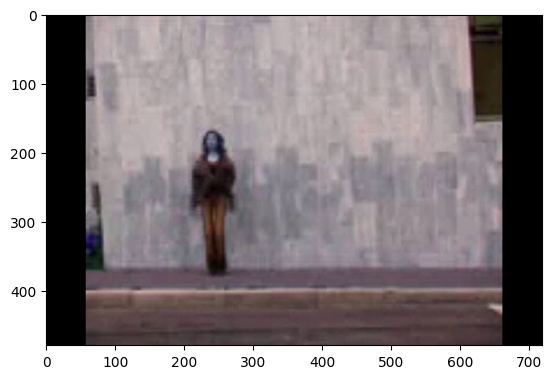

In [ ]:
src = cv2.VideoCapture(str(r'Dataset\noFights\5.mpg'))  
ret, video = src.read()
plt.imshow(video)

# Data Preprocessing

In [4]:
def load_all_frames(video_path):
    cap = cv2.VideoCapture(video_path)
  
    if not cap.isOpened():
        return {'frames':None,'frames_dim':None,'success':False}
    frames_dims = []
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        h,w,c = frame.shape
        frames_dims.append(list([0,h,w,c]))
        frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_CUBIC)
        frames.append(frame)
    
    cap.release()
    return {'frames':np.asarray(frames),'frames_dim':frames_dims,'success':True}

In [ ]:
video = load_all_frames(r'Dataset\noFights\1.mpg')

In [6]:
video['frames'][:42,].shape

(42, 128, 128, 3)

(50, 128, 128, 3)


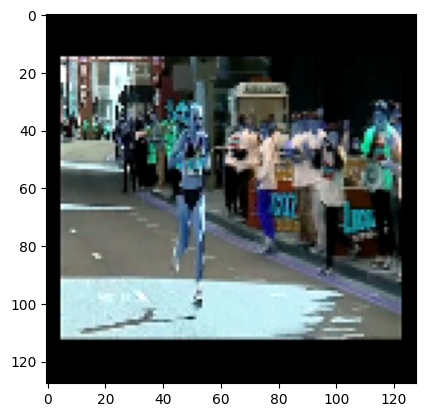

In [7]:
print(video['frames'].shape)
plt.imshow(video['frames'][2])

In [8]:
def trim_video_frames(video,max_frame):
    '''
    Args:
        video: video (collection of frames)
        max_frame: max number of frames
    '''
    f,_,_,_ = video.shape
    startf = f//2 - max_frame//2
    return video[startf:startf+max_frame, :, :, :]

def load_video(path):
    fights=[]
    video_dims = []
    for filename in os.listdir(path):
        video_path = os.path.join(path, filename)
        load_data = load_all_frames(video_path)
        if load_data['success']==False:
            continue
        video = load_data['frames']
        dims = np.asarray(load_data['frames_dim'])
        dims[:,0] = video.shape[0]
        video_dims += dims.tolist()
        fights.append(trim_video_frames(video,42)) #42 means each video trimed to 42 frames only
    return fights,video_dims

## Load the fight and no fight videos

In [ ]:
fight_videos,fight_video_dims = load_video(r'Dataset\fights')
no_fight_videos,no_fight_video_dims = load_video(r'Dataset\noFights')

fight_dataset = np.asarray( fight_videos + no_fight_videos )

## Preparing Labels [0,1]

In [11]:
# fight = 1
# no fight = 0
labels = np.concatenate([np.ones(len(fight_videos)),np.zeros(len(no_fight_videos))])

## video dimension analysis

In [ ]:
fight_dims_df = pd.DataFrame(fight_video_dims,columns=['frames','width','height','channel'])
no_fight_dims_df = pd.DataFrame(no_fight_video_dims,columns=['frames','width','height','channel'])

fight_dims_df.describe()

,frames,width,height,channel
count,4791.000000,4791.000000,4791.0,4791.0
mean,48.966187,544.741390,720.0,3.0
std,7.418289,44.990536,0.0,0.0
min,42.000000,480.000000,720.0,3.0
25%,42.000000,480.000000,720.0,3.0
50%,50.000000,576.000000,720.0,3.0
75%,60.000000,576.000000,720.0,3.0
max,60.000000,576.000000,720.0,3.0


In [14]:
no_fight_dims_df.describe()

,frames,width,height,channel
count,5050.0,5050.0,5050.0,5050.0
mean,50.0,480.0,720.0,3.0
std,0.0,0.0,0.0,0.0
min,50.0,480.0,720.0,3.0
25%,50.0,480.0,720.0,3.0
50%,50.0,480.0,720.0,3.0
75%,50.0,480.0,720.0,3.0
max,50.0,480.0,720.0,3.0


In [15]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(fight_dataset,labels,test_size=0.2,shuffle=True,random_state=42)
X_test,X_valid,y_test,y_valid = train_test_split(X_test,y_test,test_size=0.5,shuffle=True,random_state=42)

In [16]:
X_test.shape

(20, 42, 128, 128, 3)

In [17]:
import os
import io
import imageio
import ipywidgets
import numpy as np
import tensorflow as tf  # for data preprocessing only
import keras
from keras import layers, ops

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

In [18]:
# Setting seed for reproducibility
SEED = 77
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
tf.random.set_seed(SEED)

# DATA
DATASET_NAME = "fight/nofights"
BATCH_SIZE = 4
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (42, 128, 128, 3)
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 20

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 64
NUM_HEADS = 2
NUM_LAYERS = 2

In [19]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(X_train, y_train, "train")
testloader = prepare_dataloader(X_test, y_test, "test")
validloader = prepare_dataloader(X_valid, y_valid, "test")

In [20]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom", name="TubeletEmbedding")
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
    
    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

@register_keras_serializable(package="Custom", name="PositionalEncoder")
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

In [21]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=ops.gelu),
                layers.Dense(units=embed_dim, activation=ops.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS, validation_data=validloader)

    _, accuracy, top_5_accuracy = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model


model = run_experiment()

Epoch 1/20
 5/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6617 - loss: 0.8452 - top-5-accuracy: 1.0000

I0000 00:00:1718989023.735002     781 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.7265 - loss: 0.6252 - top-5-accuracy: 1.0000 - val_accuracy: 0.8571 - val_loss: 0.3428 - val_top-5-accuracy: 1.0000
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7781 - loss: 0.4443 - top-5-accuracy: 1.0000 - val_accuracy: 0.8571 - val_loss: 0.2990 - val_top-5-accuracy: 1.0000
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8120 - loss: 0.4051 - top-5-accuracy: 1.0000 - val_accuracy: 0.8571 - val_loss: 0.2929 - val_top-5-accuracy: 1.0000
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8285 - loss: 0.2696 - top-5-accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0398 - val_top-5-accuracy: 1.0000
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9661 - loss: 0.0940 - top-5-accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0343 - val_top-5-accuracy: 1.0000
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9838 - loss: 0.0558 - top-5-accuracy: 1

In [23]:
NUM_SAMPLES_VIZ = 25

testsamples, labels_ = next(iter(testloader))
testsamples, labels_ = testsamples[:NUM_SAMPLES_VIZ], labels_[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos_ = []

vds = []
for i, (testsample, label) in enumerate(zip(testsamples, labels_)):
    testsample = np.reshape(testsample.numpy(), (42, 128, 128,3))
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample * 255).astype("uint8"), "GIF", fps=5)
        videos_.append(gif.getvalue())
        
    vds.append(testsample)

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.numpy().astype("int"))
    preds.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [24]:
def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb


boxes = []
label_dict = {0: 'noFight', 1: 'Fight'}
for i in range(len(videos_)):
    
    ib = ipywidgets.widgets.Image(value=videos_[i], width=128, height=128)
    true_class = label_dict[ground_truths[i]]
    pred_class = label_dict[preds[i]]
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)

GridBox(children=(VBox(children=(HTML(value="'T: noFight | P: noFight'"), Box(children=(Image(value=b'GIF89a\x…

In [25]:
model.save('video-clf.keras')

In [26]:
new_model = tf.keras.models.load_model('/kaggle/working/video-clf.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'tubelet_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


# Model Prediction

In [27]:
label_dict = {0: 'noFight', 1: 'Fight'}
collection = []
video_path = '/kaggle/input/movies-fight-detection-dataset/Peliculas/fights/newfi18.avi'
load_data = load_all_frames(video_path)
if load_data['success']==False:
    print('Video is corrupt!!')
video = load_data['frames']
collection.append(trim_video_frames(video,42)) #42 means each video trimed to 42 frames only

# trim_video_frames(video,42)

In [28]:
@tf.function
def single_preprocess(frames: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    return frames

In [30]:
tensor = single_preprocess(trim_video_frames(video,42))
video_ = tf.squeeze(tensor, axis=-1).numpy()
# Get model prediction
output = new_model.predict(tf.expand_dims(video_, axis=0))[0]
pred = np.argmax(output, axis=0)
print(label_dict[pred])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Fight


## 